<a href="https://colab.research.google.com/github/thiakx/ModernRecSys/blob/master/Convolutional_Neural_Networks_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to this intro workbook on Convolutional Neural Networks Recommender.

For this notebook, we will walk through the steps needed to generate fashion recommendations:
1.   Convert images to embeddings
2.   Conduct Transfer Learning from ResNet
3.   Use Fastai hooks to retrieve image embeddings from step 2
4.   Use Approximate Nearest Neighbors to obtain most similar images based on the embeddings from step 3.

Results: Given a any image, we can generate recommendations for it instantly.




# Initial Setup

In [1]:
# #reference: 
# #https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903

# # install fastai for the hook and annoy for approximate nearest neighbors 
!pip install fastai
!pip install annoy
!pip install gdown

     |████████████████████████████████| 645kB 3.4MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297346 sha256=13382801abda3bb9988cbb80d490c00ea7def9cc32f6701857d3d8f664e3cae2
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
%matplotlib inline


In [3]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Tue Mar 31 01:17:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                    

## Get DeepFashion Data

DeepFashion data set: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

We are using v1 of the data, with 24K+ images. 

In [11]:
# get the meta data
url = 'https://drive.google.com/uc?id=1d1nWNVHdIAvzuGyaSrajuPIffQTjbnsp'
output = 'list_category_cloth.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1quO7Fck8MsKum4lzeyMSbbSbL6yGAIDJ'
output = 'list_category_img.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1_rg5_UZ-ZXkcg0yM_-PlN9yLtYT13sSx'
output = 'list_eval_partition.txt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1d1nWNVHdIAvzuGyaSrajuPIffQTjbnsp
To: /content/list_category_cloth.txt
100%|██████████| 882/882 [00:00<00:00, 1.31MB/s]
Downloading...
From: https://drive.google.com/uc?id=1quO7Fck8MsKum4lzeyMSbbSbL6yGAIDJ
To: /content/list_category_img.txt
21.4MB [00:00, 55.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_rg5_UZ-ZXkcg0yM_-PlN9yLtYT13sSx
To: /content/list_eval_partition.txt
22.2MB [00:00, 99.7MB/s]


'list_eval_partition.txt'

In [5]:
# get the images
root_path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'img.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile("img.zip","r") as zip_ref:
    zip_ref.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
2.68GB [02:20, 19.1MB/s]


In [0]:
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [13]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head()

image_path dataset category
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg   train   Blouse
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg   train   Blouse
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg     val   Blouse
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg   train   Blouse
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg    test   Blouse

# Convert images to embeddings

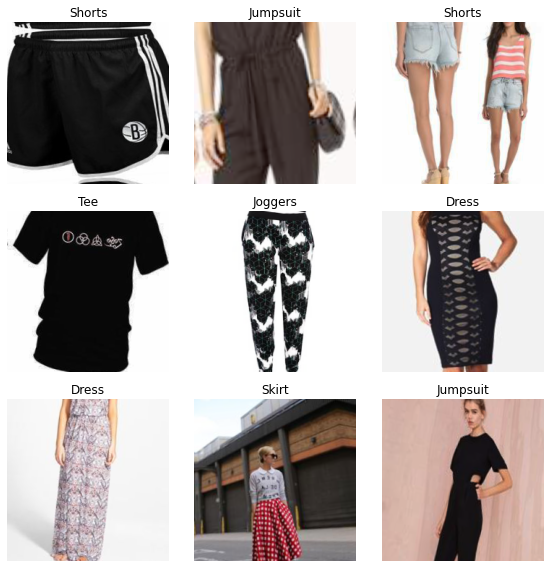

In [14]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset']=='train'].index),
    (data_df[data_df['dataset']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

# Conduct Transfer Learning from ResNet

## Resnet18

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.20E-02


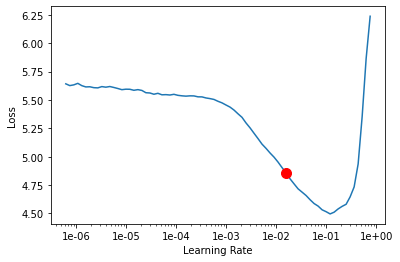

In [0]:
# see models available: https://docs.fast.ai/vision.models.html
# many options for Resnet, the numbers are the number of layers. 
# More layers are generally more accurate but take longer to train: resnet18, resnet34, resnet50, resnet101, resnet152
# get top 1 and top 5 accuracy
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.resnet18
model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [0]:
learner.fit_one_cycle(3, max_lr=1e-02)

## Evaluate Model 

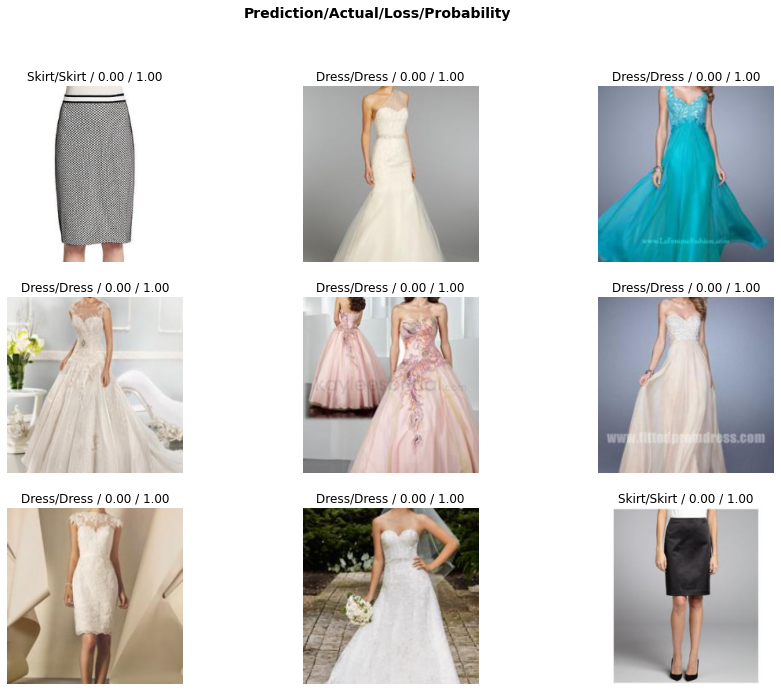

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

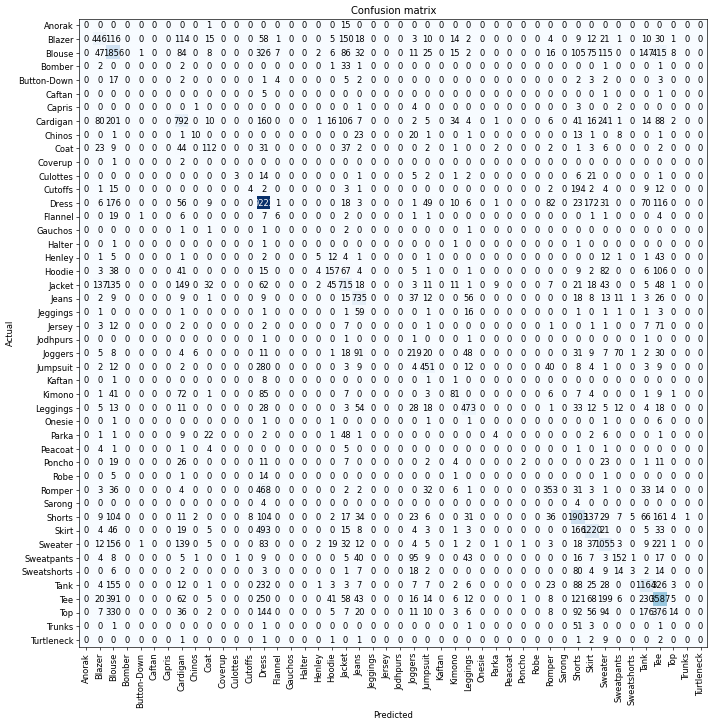

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
# saving the model (temporary, will lose model once environment resets)
learner.save('resnet18-fashion')

In [0]:
# saving the model (permanent), need to enter authorization code
drive.mount('/content/gdrive')
learner.save('/content/gdrive/My Drive/resnet18-fashion')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


PosixPath('models/resnet18-fashion.pth')

In [0]:
# view model details
learner.model.module

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Squeezenet - small model alternative

Squeezenet is used when resources are limited. The model itself is smaller than 5mb but its accuracy is much lower than even Resnet18. 

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.45E-02


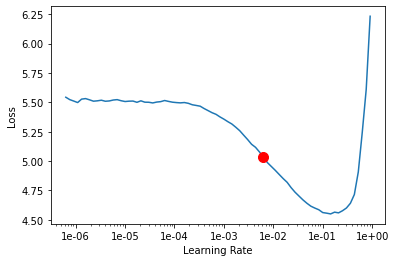

In [0]:
pretrained_model = models.squeezenet1_0
model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [0]:
learner.fit_one_cycle(3, max_lr=1e-02)

# Use Fastai hooks to retrieve image embeddings

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [0]:
# load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.resnet18
model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
model_path = "/content/gdrive/My Drive/resnet18-fashion"
learner = load_learner(data, pretrained_model, model_metrics, model_path)

In [0]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [0]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

img_path  ...                                         embeddings
0       ./img/Sheer_Pleated-Front_Blouse/img_00000001.jpg  ...  [3.9265947341918945, 47.80828094482422, 15.349...
1       ./img/Sheer_Pleated-Front_Blouse/img_00000002.jpg  ...  [18.256385803222656, -45.124752044677734, -6.8...
2       ./img/Sheer_Pleated-Front_Blouse/img_00000004.jpg  ...  [1.5310372114181519, -8.956171989440918, 24.60...
3       ./img/Sheer_Pleated-Front_Blouse/img_00000008.jpg  ...  [8.178252220153809, 34.692440032958984, 1.5570...
4       ./img/Sheer_Pleated-Front_Blouse/img_00000009.jpg  ...  [10.93298625946045, 31.95085334777832, 30.9419...
...                                                   ...  ...                                                ...
249217  ./img/Paisley_Print_Babydoll_Dress/img_0000003...  ...  [16.33787727355957, 17.817060470581055, 25.745...
249218  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [21.687116622924805, 31.771949768066406, 6.695...
249219  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [14.117104530334473, 23.93145179748535, 33.174...
249220  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [31.950626373291016, 34.10627746582031, -29.02...
249221  ./img/Paisley_Print_Babydoll_Dress/img_0000005...  ...  [13.248711585998535, 20.740785598754883, 24.49...

[249222 rows x 4 columns]

# Use Approximate Nearest Neighbors to obtain most similar images

In [0]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 

def show_similar_images(similar_images_df):
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                 [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']])

# more tree = better approximation
ntree = 100
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

1.8360614776611328 ms
Dress


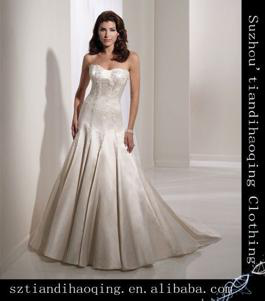

In [0]:
# # preview target image
# img_index = 181818
# img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
# open_image(img_id)

# very fast query speed, ~5ms
img_id, img_label, similar_images_df = get_similar_images_annoy(annoy_tree, 181818)

print(img_label)
open_image(img_id)

In [0]:
similar_images_df

img_path  ...                                         embeddings
172630  ./img/Lace_Crisscross-Back_Dress/img_00000008.jpg  ...  [-8.247444152832031, 58.45602798461914, 31.911...
181156   ./img/Eyelash_Lace_A-Line_Dress/img_00000029.jpg  ...  [-20.71478271484375, 27.802074432373047, 39.21...
179201  ./img/Strapless_Pleated_Chiffon_Dress/img_0000...  ...  [-1.5384241342544556, 34.21005630493164, 34.24...
190432  ./img/Sequin_Embroidered_Lace_Dress/img_000000...  ...  [-22.46102523803711, 27.625225067138672, 20.23...
203839  ./img/Embroidered_Lace_A-Line_Dress/img_000000...  ...  [-12.086936950683594, 14.819774627685547, 32.5...
246532       ./img/Shirred_Chiffon_Dress/img_00000064.jpg  ...  [-5.829349040985107, 35.26643371582031, 37.592...
146255  ./img/Varsity_Stripe_A-Line_Dress/img_00000002...  ...  [-15.35402774810791, 32.351158142089844, 30.68...
206167      ./img/Classic_Babydoll_Dress/img_00000041.jpg  ...  [-19.502792358398438, 4.064782619476318, 28.93...
155876  ./img/Damask_Pattern_A-Line_Dress/img_00000043...  ...  [-14.287186622619629, 22.047571182250977, 26.4...
180883         ./img/Pleated_Woven_Dress/img_00000065.jpg  ...  [-15.833378791809082, 20.355669021606445, 13.4...
172722           ./img/Lace_Halter_Dress/img_00000027.jpg  ...  [-7.907353401184082, 39.689430236816406, 44.78...
196322  ./img/Paisley-Embroidered_A-Line_Dress/img_000...  ...  [-22.057758331298828, 8.914151191711426, 30.05...

[12 rows x 4 columns]

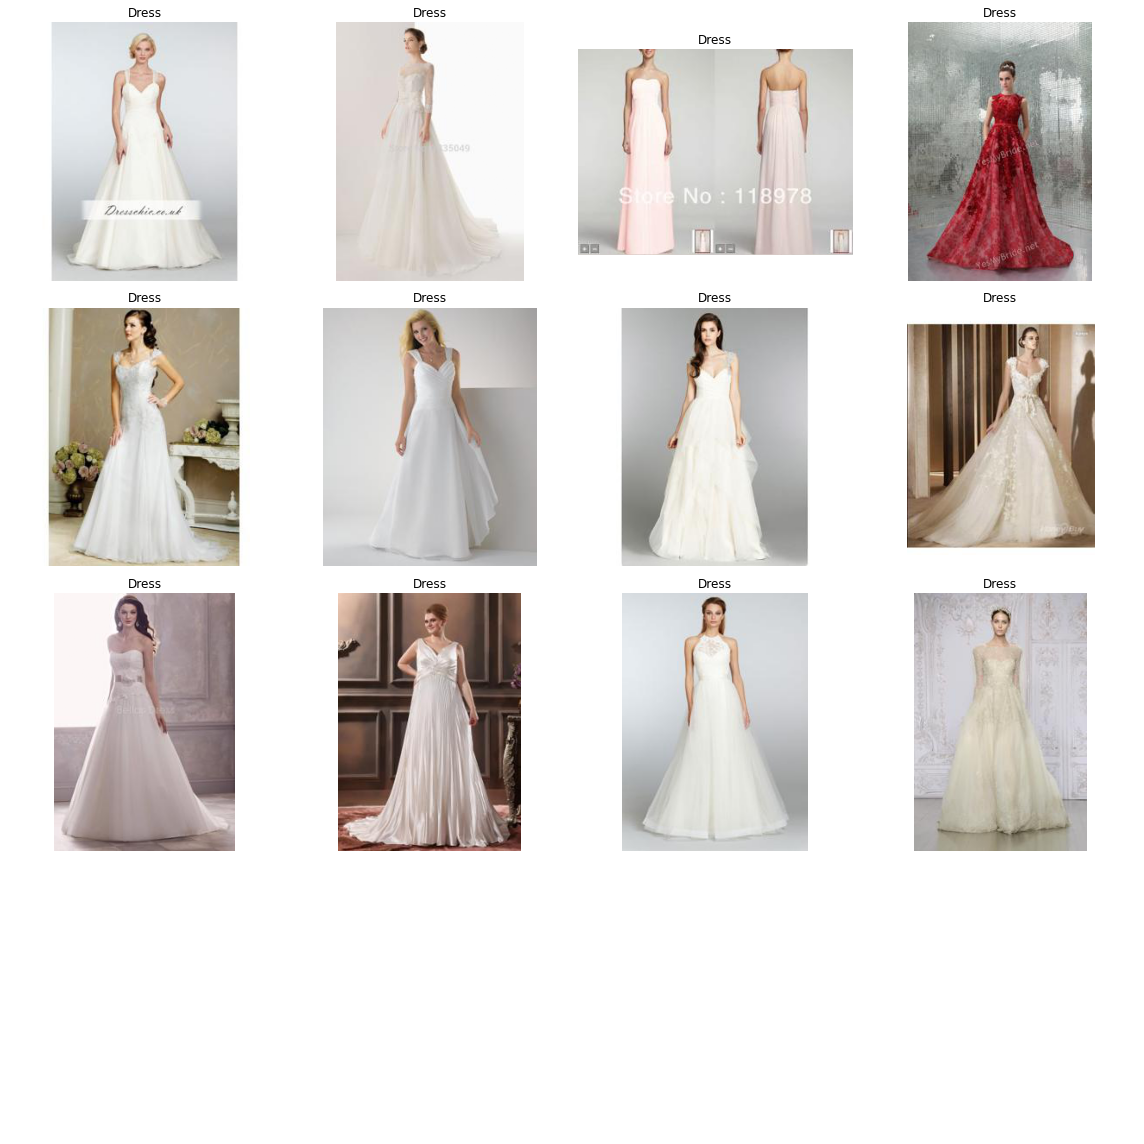

In [0]:
show_similar_images(similar_images_df)

2.8870105743408203 ms
Tee


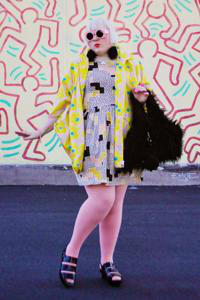

In [0]:
img_id, img_label, similar_images_df  = get_similar_images_annoy(annoy_tree, 77777)

print(img_label)
open_image(img_id)

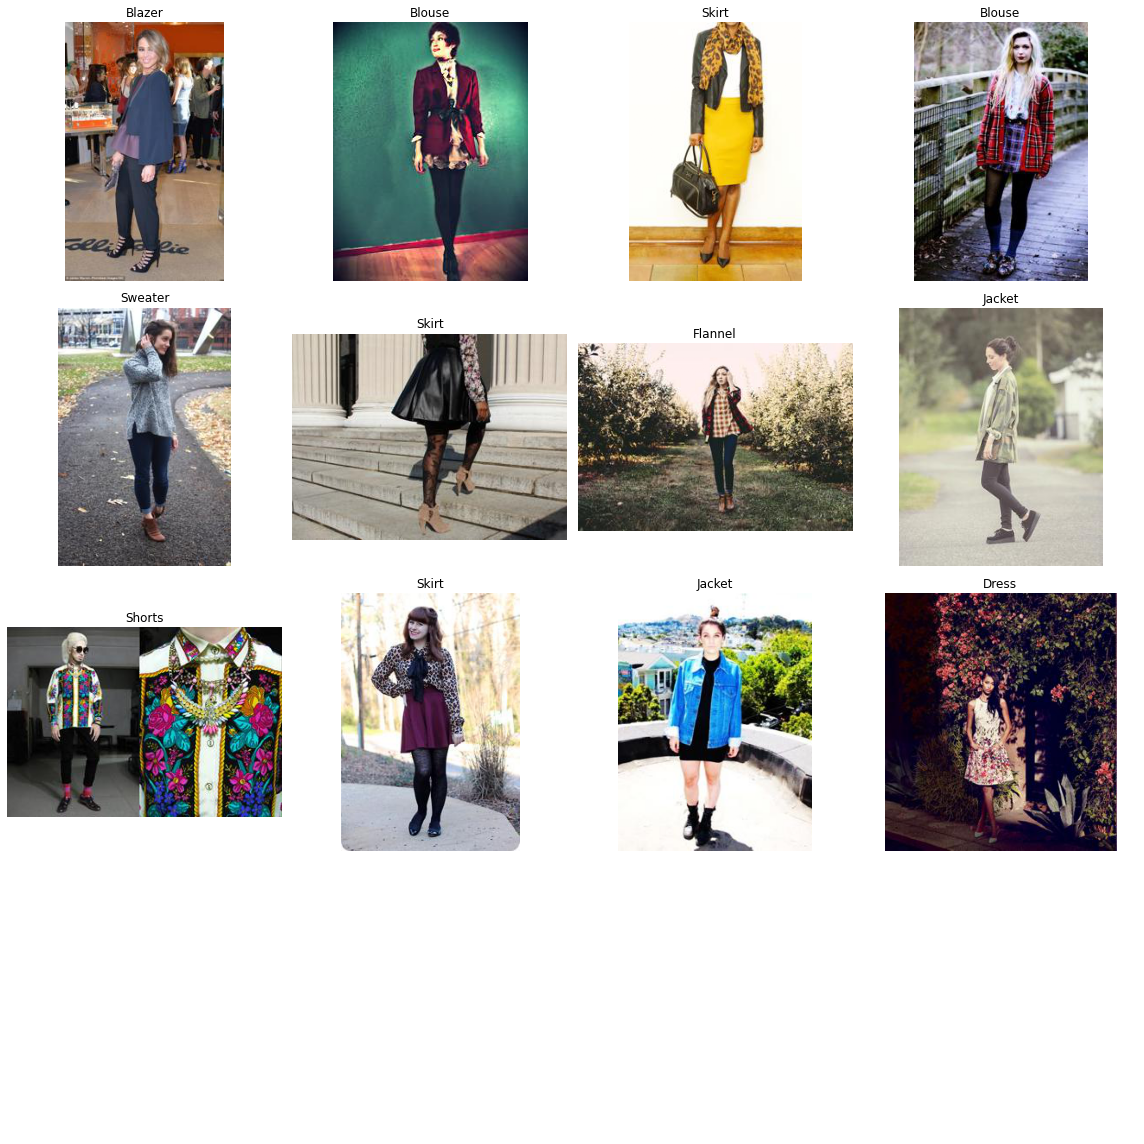

In [0]:
show_similar_images(similar_images_df)

1.9080638885498047 ms
Shorts


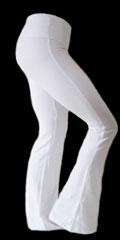

In [0]:
img_id, img_label, similar_images_df  = get_similar_images_annoy(annoy_tree, 123456)

print(img_label)
open_image(img_id)

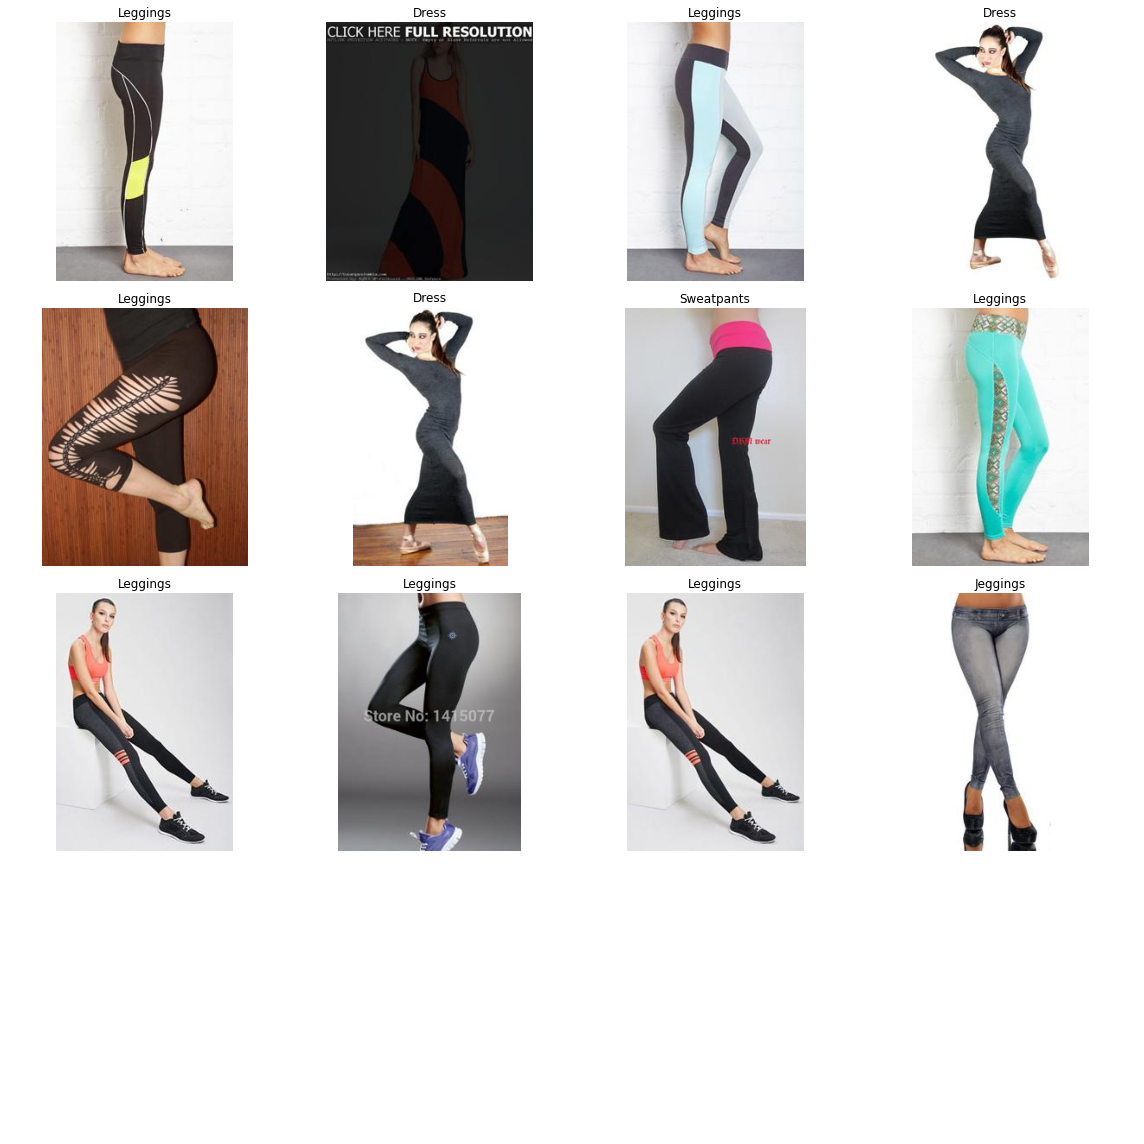

In [0]:
show_similar_images(similar_images_df)

2.0265579223632812 ms
Sweater


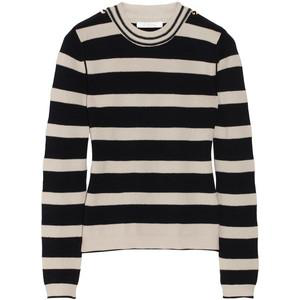

In [0]:
img_id, img_label, similar_images_df  = get_similar_images_annoy(annoy_tree, 33333)

print(img_label)
open_image(img_id)


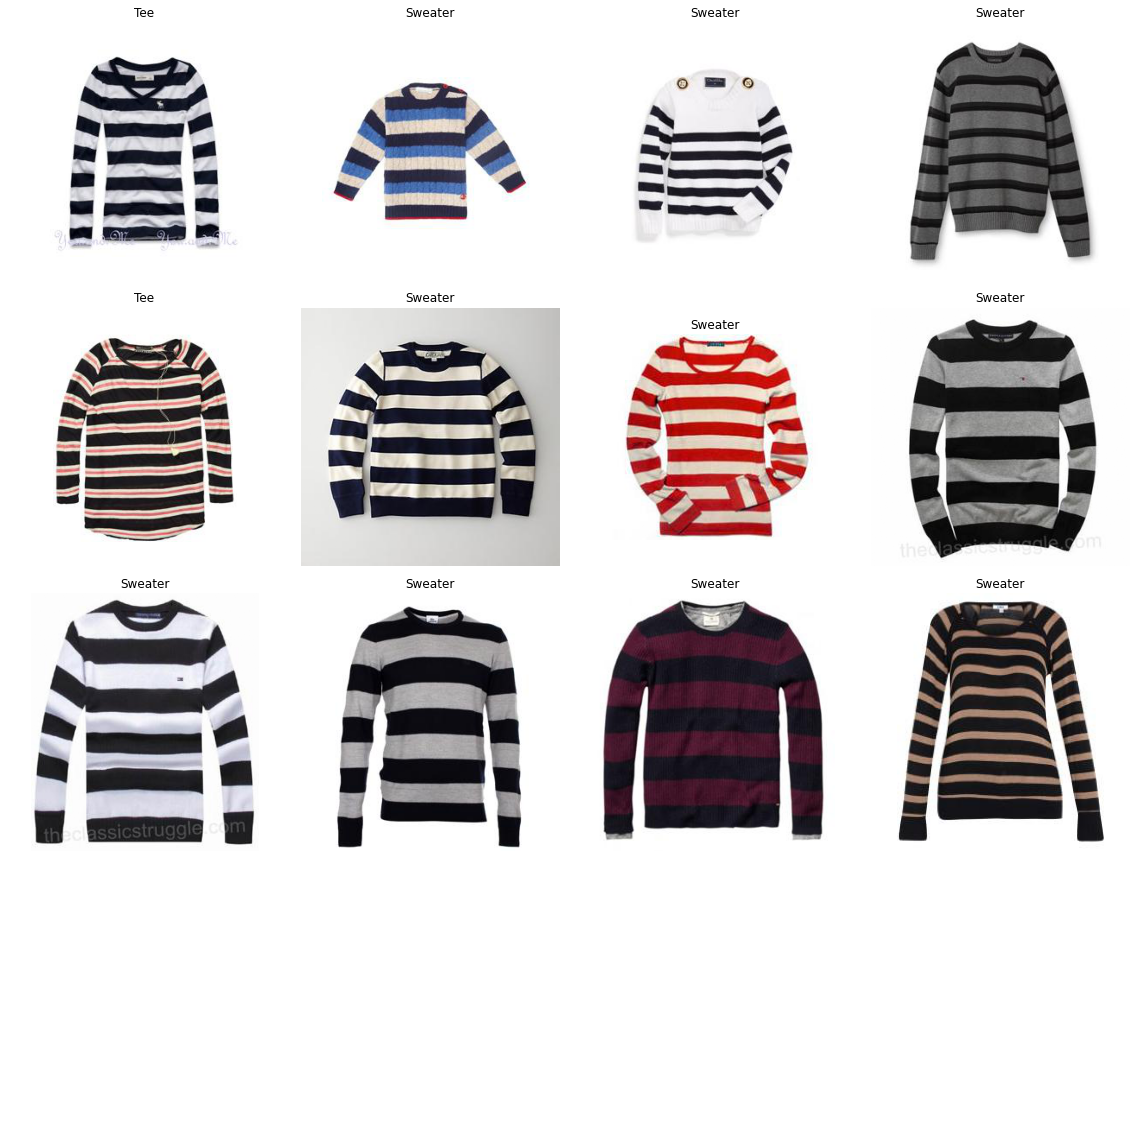

In [0]:
show_similar_images(similar_images_df)



* We observe that some items are easier to recommend, for example this stripped sweater.
* White jeans are a little harder, we seem to end with up leggings, black pants and blue jeans
* While the interesting outfit results in very diverse set of recommendations. It seems that this method is not very good in matching complex colors, layers, and outfits.





# Reflections

*  For Annoy, test with different number of trees and distance metrics. Do you observe any difference in terms of speed and items returned? 
*  For Annoy, test with different target images. Are the recommendations "good"? How can the recommendations be improved? 
* What happens if we swap out the pretrained_model to resnet152? What will you expect from running a "more accurate" model?
* Will we be able to apply this entire workflow on different images? For example covid-19 x-ray images?



